<a href="https://colab.research.google.com/github/HYUNSOOLEE-6839/colab-Deep-Learning/blob/main/22_Cifar_10_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar-10 이미지 분류(Data Augmentation)

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
import os
import numpy as np

In [2]:
# 실행할 때 마다 같은 결과를 출력하기 위한 seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 나중에 지정될 변수의 값을 미리 세팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')

In [4]:
     # The data, split between train and test sets:
     (x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
     print('x_train shape:', x_train.shape)
     print(x_train.shape[0], 'train samples')
     print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 데이터 확인

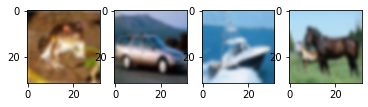

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(x_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(x_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(x_train[12], interpolation="bicubic")
plt.grid(False)

### 자료형을 실수로 변환한 후 정규화

In [6]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [7]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

### 모델 정의/설정/학습

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, input_dim=784, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [9]:
# initiate RMSprop optimzer
from tensorflow.keras.optimizers import RMSprop
opt=RMSprop(learning_rate=0.0001, decay=1e-6)

In [10]:
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/cifar10-aug-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0
)
datagen.fit(x_train)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, stratify=y_train, train_size=0.2, random_state=seed
)

In [14]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(x_valid, y_valid), callbacks=[checkpointer, early_stopping_callback])

Epoch 1/100
313/313 [==============================] - 10s 26ms/step - loss: 2.2301 - accuracy: 0.1558 - val_loss: 2.0064 - val_accuracy: 0.2927

Epoch 00001: val_loss improved from inf to 2.00644, saving model to model/cifar10-aug-01-2.0064.hdf5
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 2.0259 - accuracy: 0.2540 - val_loss: 1.8329 - val_accuracy: 0.3555

Epoch 00002: val_loss improved from 2.00644 to 1.83287, saving model to model/cifar10-aug-02-1.8329.hdf5
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 1.8739 - accuracy: 0.3088 - val_loss: 1.7125 - val_accuracy: 0.3947

Epoch 00003: val_loss improved from 1.83287 to 1.71249, saving model to model/cifar10-aug-03-1.7125.hdf5
Epoch 4/100
313/313 [==============================] - 8s 25ms/step - loss: 1.7893 - accuracy: 0.3406 - val_loss: 1.6818 - val_accuracy: 0.4008

Epoch 00004: val_loss improved from 1.71249 to 1.68185, saving model to model/cifar10-aug-04-1.6818.hdf5
Epo

KeyboardInterrupt: ignored

In [23]:
from tensorflow.keras.models import load_model

best_model = load_model('./model/cifar10-aug-56-0.9003.hdf5')
acc = best_model.evaluate(x_test, y_test, verbose=1)[1]
print(f"\n Test Accuracy:{acc:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.8998 - accuracy: 0.6903

 Test Accuracy:0.6903


### 훈련과정 시각화

In [24]:
# 검증셋의 오차
# y_loss에 테스트셋으로 실험 결과의 오차 값을 저장
y_loss=history.history['loss']
# y_loss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss=history.history['val_loss']
# y_acc에 테스트셋으로 실험 결과의 오차 값을 저장
y_acc=history.history['accuracy']

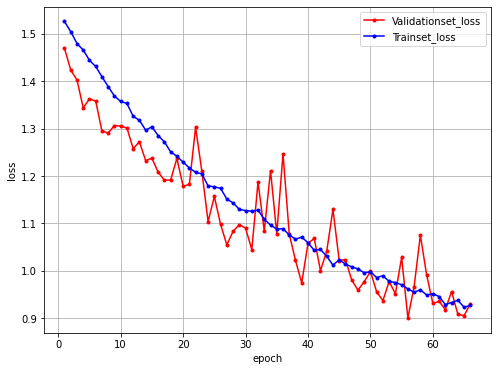

In [25]:
x_len = np.arange(1, len(y_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker=".", c="red", label='Validationset_loss')
plt.plot(x_len, y_loss, marker=".", c="blue", label='Trainset_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

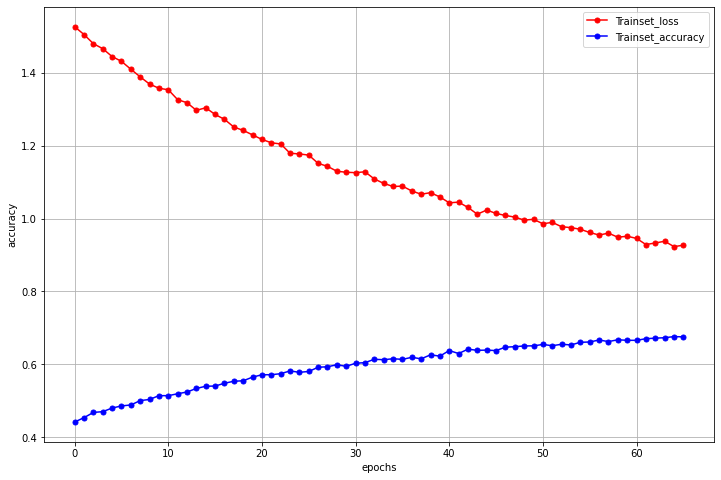

In [26]:
x_len = np.arange(len(y_acc))
plt.figure(figsize=(12,8))
plt.plot(x_len, y_loss, "o-", c="red", label='Trainset_loss', markersize=5)
plt.plot(x_len, y_acc, "o-", c="blue", label='Trainset_accuracy', markersize=5)
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
plt.show()